### ctxt Packing
Joonwoo Lee et al 2021 paces a channel of an image in a ctxt, 
using only 1024 slots out of 16384. (sparse packing)

### Narrow Resnet
Their 'ResNet-20' is a modified and simplified version of the original ResNet. 
First, they use only three basic blocks, while Resnet-18 consists of four. 
Second, they reduced the number of channels.  
The first conv outputs 16 channels, instad of 64. 
The final number of channels is thus only 64. (Resnet-18 with four basic blocks ends up with 512 channels)
This modification is reasonable because computations are done in per-channel manner. 
The total computing cost grows linearly with growing number of channels.  

### AvgPool
마지막에 AvgPool 하나와 FC가 하나 있음. 8x8 이미지를 8x8 kernel로 AvgPool해서 1 x 64-channel 이 됨. 
그 다음에 64개의 ctxt가 하나의 ctxt로 합쳐짐.  -- 어떻게 잘 합칠까? 

### Softmax
Approximate softmax는 계산량이 상당히 많음. 
그러다고 softmax 없이 training을 할 수는 없음 (argmax는 differentiable하지 않으므로)
1. softmax로 훈련한 뒤에 argmax로 교체해서 evaluate하거나 
2.그 전에 decrypt해서 plain text에 softmax 계산하거나


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt 
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = "cuda"

CUDA is available!  Training on GPU ...


Prepare Train / test data sets

In [3]:
num_workers = 0
batch_size = 32
valid_size = 0.2


## Scale 
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (2.5, 2.5, 2.5))
     ])

train_data = datasets.CIFAR10('data', train=True,
                              download=True,
                              transform=transform
                             )
test_data = datasets.CIFAR10('data', train=False,
                             download=True, 
                             transform=transform
                            )

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


옛날 버전이라 에러 나는 듯. 

RELU 결과가 -0.9?
ReLU로 들어가는 값이 -5.x로 안전한 영역을 지나쳤음. 

### 텐서 크기 
1024 * 3  -> 1024 * 32 -> 256 * 32 -> 256 * 64 -> 64 * 64 -> 64 * 128 -> 16 * 128 -> 2048 -> 256 -> 10


1024 * 32는 여러 개의 ctxt에 담아야함.  

아니면 첫번째 convolution 채널을 작게 유지하고,   
average pooling을 묶어서 계산할 수는 없을까.  

## Polynomial fitting

In [4]:
from numpy.polynomial import chebyshev
from numpy import polynomial as P

def sigmoid(x):
    return 1./(1.+np.exp(-x))

def tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x)+np.exp(-x))

def ReLU(x):
    return x * (x > 0)

def LeakyReLU(x):
    return np.maximum(0.1*x, x)

def _exp(x, a=1):
    return a*(np.exp(x)-1)

def ELU(x, a=1):
    return np.piecewise(x, [x<0, x>=0], [lambda x:_exp(x,a=a), lambda x:x])

def swish(x):
    return x * sigmoid(x)

def GELU(x):
    return 0.5*x*(1 + tanh(np.sqrt(2/np.pi)*(x+0.044715*x**3)))

### Comparison among activations

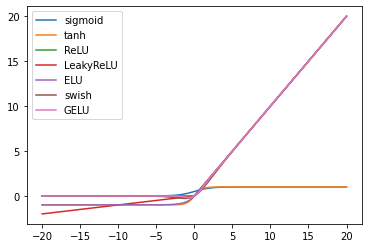

In [8]:
functions = [sigmoid, tanh, ReLU, LeakyReLU, ELU, swish, GELU]

xx = np.linspace(-20, 20, 600)

fig, ax = plt.subplots()
for ff in functions:
    ax.plot(xx, ff(xx), label=ff.__name__)
    
plt.legend()
plt.show()

### fitting

In [9]:
with open("coeffs.txt", 'w') as f:
    for deg in range(5,14):
        fig, axs = plt.subplots(3,3, figsize=(16,12))
        axs = axs.ravel()
        fittings = []
        for ax, fun in zip(axs,functions):
            fitted = Chebyshev.fit(xx, fun(xx), deg=deg)
            fittings.append((fun.__name__, fitted))

            ax.plot(xx, fun(xx), label=fun.__name__)
            ax.plot(xx, fitted(xx), label=fun.__name__+"-fit", ls="--")
            ax.legend()


            line = f"{deg} {fun.__name__:<15}" + np.array2string(fitted.coef, 
                                                                 max_line_width=200, 
                                                                 floatmode='fixed', 
                                                                 suppress_small=True, 
                                                                 precision=10)[1:-1]
            f.write(line+'\n')

        fig.suptitle(f"Degree: {deg}")
        plt.tight_layout()
        plt.savefig(f"Chebyshev_fit_{deg}.png", facecolor="white")
        plt.close()
    


In [10]:
fittings

[('sigmoid',
  Chebyshev([ 5.00000000e-01,  6.36876710e-01,  1.06055826e-16, -2.01464114e-01,
         -1.67846017e-16,  1.18236629e-01, -5.78389116e-17, -7.11774879e-02,
         -1.37951114e-16,  5.58717685e-02, -1.28227339e-16, -3.12201832e-02,
         -1.68220340e-16,  3.42221723e-02], domain=[-20.,  20.], window=[-1.,  1.])),
 ('tanh',
  Chebyshev([-5.21687506e-17,  1.28200217e+00, -6.36334956e-16, -4.10059017e-01,
         -5.16449284e-17,  2.59433334e-01, -3.85592744e-16, -1.60428601e-01,
          0.00000000e+00,  1.45158366e-01, -2.88511513e-16, -8.36530330e-02,
          1.18555287e-16,  1.10335068e-01], domain=[-20.,  20.], window=[-1.,  1.])),
 ('ReLU',
  Chebyshev([ 6.36083735e+00,  1.00000000e+01,  4.23319554e+00,  3.45380177e-15,
         -8.60397310e-01,  3.69461001e-15,  3.50984243e-01,  4.27323999e-15,
         -2.16978919e-01, -4.05034834e-15,  1.09953873e-01,  8.05667696e-16,
         -1.15997735e-01, -8.38724638e-15], domain=[-20.,  20.], window=[-1.,  1.])),
 ('L

SWISH는 성능이 매우 만족스러움

### Approximate activation function

function fitting은 Chebyshev로 하되, range와 deg를 바꿔가며 최적의 값을 찾을 것. 
* Multiplication detph는 log2(depth)이므로 (?) deg = 16 아니면 32를 쓰는게 좋을 듯.  -- 확인 필요

* Validation test할 때 activation input의 min,max 범위 체크 필요 
* min, max 범위가 제대로 커버 되었을 경우 Loss가 nan이 아닌 값이 나와야 함. 


In [5]:
from approximate import approx_relu

activation = lambda x : 40 * approx_relu(x/40, degree = 4, repeat=3)

In [6]:
from fase.nn import ResNet20 

xx = np.linspace(-35, 28, 500)

model = ResNet20.ResNet9(10, activation)#approx_relu8) # boundary 상관 없음
model.to(device)

ResNet9(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (basicblock1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (shortcut): Sequential()
  )
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1,

## Optimizer

In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
# For ResNet
optimizer = optim.SGD(model.parameters(), lr=.01, weight_decay=5e-4, momentum = 0.9)
#optimizer = optim.Adam(model.parameters(), lr=.001, weight_decay=0.005)

## Training

activation을 approximate relu로 설정하면 loss = nan 나옴. 
1. input range 체크 
2. 중간값 범위 체크

In [10]:
n_epochs = 20
train_losslist=[]
valid_loss_min = np.Inf 
model.to(device)

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    
    model.train()
    
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        #print("DATA", data[0,0,0])
        output = model(data)
        #print("weight", model.conv1.weight[0,0,0])
        #print(output[0,:])
        #print(output.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        #print("VALID-------------------------------------------------------------------")
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'ResNet9avg_minimaxReLU.pt')
        valid_loss_min = valid_loss
        

Epoch: 1 	Training Loss: 1.061533 	Validation Loss: 0.211548
Validation loss decreased (inf --> 0.211548).  Saving model ...
Epoch: 2 	Training Loss: 0.728551 	Validation Loss: 0.172021
Validation loss decreased (0.211548 --> 0.172021).  Saving model ...
Epoch: 3 	Training Loss: 0.590914 	Validation Loss: 0.144951
Validation loss decreased (0.172021 --> 0.144951).  Saving model ...
Epoch: 4 	Training Loss: 0.505605 	Validation Loss: 0.128344
Validation loss decreased (0.144951 --> 0.128344).  Saving model ...
Epoch: 5 	Training Loss: 0.441682 	Validation Loss: 0.116670
Validation loss decreased (0.128344 --> 0.116670).  Saving model ...
Epoch: 6 	Training Loss: 0.392055 	Validation Loss: 0.116032
Validation loss decreased (0.116670 --> 0.116032).  Saving model ...
Epoch: 7 	Training Loss: 0.346934 	Validation Loss: 0.114462
Validation loss decreased (0.116032 --> 0.114462).  Saving model ...
Epoch: 8 	Training Loss: 0.309078 	Validation Loss: 0.120077
Epoch: 9 	Training Loss: 0.272322 

KeyboardInterrupt: 

In [11]:
model.load_state_dict(torch.load('ResNet9avg_minimaxReLU.pt'))

<All keys matched successfully>

### Validation

In [12]:
# track test loss
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, 
    num_workers=num_workers)

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.to(device)
model.eval()
# iterate over test data
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    #### VALIDATE 
    output = model.validate(data)
    #model.minmax=[torch.inf, -torch.inf]
    ###    

    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

#torch.save(model.state_dict(), "Net_3C2F.pt")

activation Input Min, Max
[tensor(-23.5180, device='cuda:0', grad_fn=<MinBackward1>), tensor(24.6825, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-28.0306, device='cuda:0', grad_fn=<MinBackward1>), tensor(24.6825, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-28.0306, device='cuda:0', grad_fn=<MinBackward1>), tensor(24.6825, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-28.0306, device='cuda:0', grad_fn=<MinBackward1>), tensor(24.6825, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-28.0306, device='cuda:0', grad_fn=<MinBackward1>), tensor(24.6825, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-28.0306, device='cuda:0', grad_fn=<MinBackward1>), tensor(24.6825, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-28.0306, device='cuda:0', grad_fn=<MinBackward1>), tensor(24.6825, device='cuda:0', grad_fn=<MaxBackw

activation Input Min, Max
[tensor(-29.5237, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-29.5237, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-29.5237, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-29.5237, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-29.5237, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-29.5237, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-29.5237, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackw

activation Input Min, Max
[tensor(-30.0194, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackw

activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(27.5936, device='cuda:0', grad_fn=<MaxBackw

activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-33.2541, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackw

activation Input Min, Max
[tensor(-34.1609, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-34.1609, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-34.1609, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-34.1609, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-34.1609, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-34.1609, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackward1>)]
activation Input Min, Max
[tensor(-34.1609, device='cuda:0', grad_fn=<MinBackward1>), tensor(28.9005, device='cuda:0', grad_fn=<MaxBackw


xx = np.linspace(-33, 26, 1000)
activation = Chebyshev.fit(xx, ELU(xx), deg=31)


Test Loss: 0.951408

Test Accuracy of airplane: 77% (778/1000)
Test Accuracy of automobile: 83% (838/1000)
Test Accuracy of  bird: 66% (666/1000)
Test Accuracy of   cat: 73% (734/1000)
Test Accuracy of  deer: 72% (727/1000)
Test Accuracy of   dog: 55% (553/1000)
Test Accuracy of  frog: 57% (577/1000)
Test Accuracy of horse: 77% (771/1000)
Test Accuracy of  ship: 33% (335/1000)
Test Accuracy of truck: 76% (760/1000)

Test Accuracy (Overall): 67% (6739/10000)



xx = np.linspace(-35, 28, 100)
activation = Chebyshev.fit(xx, ELU(xx), deg=63)



Test Loss: 0.616481

Test Accuracy of airplane: 79% (791/1000)
Test Accuracy of automobile: 89% (899/1000)
Test Accuracy of  bird: 69% (691/1000)
Test Accuracy of   cat: 71% (715/1000)
Test Accuracy of  deer: 81% (815/1000)
Test Accuracy of   dog: 67% (674/1000)
Test Accuracy of  frog: 86% (864/1000)
Test Accuracy of horse: 81% (814/1000)
Test Accuracy of  ship: 84% (848/1000)
Test Accuracy of truck: 86% (860/1000)

Test Accuracy (Overall): 79% (7971/10000)